In [33]:
# Citations
# GBIF.org (15 June 2025) GBIF Occurrence Download  https://doi.org/10.15468/dl.mhxdcy
# Data was obtained from GBIF-NZ, it includes records from 6 datasets: iNaturalist Research-grade Observations Observation.org, Nature data from around the World, Auckland Museum Land Vertebrates Collection, Xeno-canto - Bird sounds from around the world, NABU|naturgucker, MVZ Egg and Nest Collection (Arctos)
# There were 4258 occurances in the original dataset, but this was reduced to 4202 occurances as a result of data cleaning.
# Of the original 4258 occurances, 581 were takahe (Porphyrio hochstetteri) and 3621 were pukeko (Porphyrio melanotus subsp. melanotus).
# In the cleaned dataset 550 were takahe (Porphyrio hochstetteri) and 3557 were pukeko (Porphyrio melanotus subsp. melanotus).
# The data cleaning and downloading of the images was performed in Rstudio.
# Made using Python version 3.12.9


In [ ]:
# loading packages, using python 3.12.9
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset, random_split
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision import datasets
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from torch.optim.lr_scheduler import StepLR


In [35]:
# Defining the EfficientNet-B3 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading pretrained EfficientNet-B3
weights = EfficientNet_B3_Weights.IMAGENET1K_V1
model = efficientnet_b3(weights=weights)

# Replacing the classifier head for 2 classes: EfficientNet_B3 has `model.classifier = nn.Sequential( Dropout, Linear )`
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 2)

# Move to GPU/CPU
model = model.to(device)

# Print out to verify
print(model)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [ ]:
# Using standard ImageNet stats
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

# Transforming the data by resizing the images, converting the images to tensors and normalizing the images
Transform_data = transforms.Compose([
    # Resizes images to 300 by 300 pixels
    transforms.Resize((300, 300)),
    # randomly horizontally flips images
    transforms.RandomHorizontalFlip(p = 0.2),
    # randomly rotates images
    transforms.RandomRotation(degrees = (0, 30)),
    # Randomly alters the visual appearance of the images during training
    transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2, hue = 0.1),
    # turns images into tensors
    transforms.ToTensor(),
    # Normalises the data
    transforms.Normalize(mean=mean, std=std)
])

# random data augmentation techniques are not used on the validation set to avoid overfitting
V_Transform_data = transforms.Compose([
    # Resizes images to 300 by 300 pixels
    transforms.Resize((300, 300)),
    # turns images into tensors
    transforms.ToTensor(),
    # Normalises the data
    transforms.Normalize(mean=mean, std=std)
])

# Importing data and splitting the dataset into training, validation and testing sets
Images = ImageFolder(root = "Train_data", transform = None)

# 3) Split into train/val/test once, capturing indices
total_size = len(Images)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size  # Ensures total sums correctly

# Setting a seed to ensure reproducible results
generator = torch.Generator().manual_seed(0)

training_subset, validation_subset, Test_subset = random_split(Images, [train_size, val_size, test_size], generator = generator)
train_idx = training_subset.indices
val_idx   = validation_subset.indices
test_idx  = Test_subset.indices

# Creating three ImageFolder datasets with transforms, and sub-indexing them:
train_ds = Subset(ImageFolder("Train_data", transform = Transform_data), train_idx)
val_ds   = Subset(ImageFolder("Train_data", transform = V_Transform_data),  val_idx)
test_ds  = Subset(ImageFolder("Train_data", transform = V_Transform_data),  test_idx)

# Build your loaders
train_loader = DataLoader(train_ds, batch_size=35, shuffle = True)
validation_loader = DataLoader(val_ds, batch_size=35, shuffle = False)
test_loader  = DataLoader(test_ds, batch_size=35, shuffle = False)


In [ ]:
# Adding class weights to adjust for imbalanced data set (There are signficantly more pukeko than takahe in the dataset, pukeko make up around 87% of the data, and takahe make up about 13%)
class_weights = torch.tensor([1, 6], dtype = torch.float)
# Defining the loss function and the optimiser
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight = class_weights)

# Freeze all but the head for faster head-only training
# for name, param in model.named_parameters():
#    if "classifier" not in name:
#        param.requires_grad = False

In [ ]:
train_loss = []
for epoch in range(10):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # plain forward/backward
        logits = model(images)
        loss   = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        # tracking
        preds = logits.argmax(dim=1)
        running_loss += loss.item() * images.size(0)
        correct      += (preds == labels).sum().item()
        total        += images.size(0)

    epoch_loss = running_loss / total
    train_loss.append(epoch_loss)
    epoch_acc  = correct / total * 100
    print(f"Epoch {epoch+1}/{10} — loss: {epoch_loss:.4f}, acc: {epoch_acc:.2f}%")

Epoch 1/10 — loss: 0.5302, acc: 79.99%
Epoch 2/10 — loss: 0.4533, acc: 82.46%
Epoch 3/10 — loss: 0.4306, acc: 83.12%
Epoch 4/10 — loss: 0.4049, acc: 83.37%
Epoch 5/10 — loss: 0.3930, acc: 84.52%
Epoch 6/10 — loss: 0.3871, acc: 84.13%
Epoch 7/10 — loss: 0.3876, acc: 84.31%
Epoch 8/10 — loss: 0.3803, acc: 84.27%
Epoch 9/10 — loss: 0.3617, acc: 85.42%
Epoch 10/10 — loss: 0.3600, acc: 85.42%


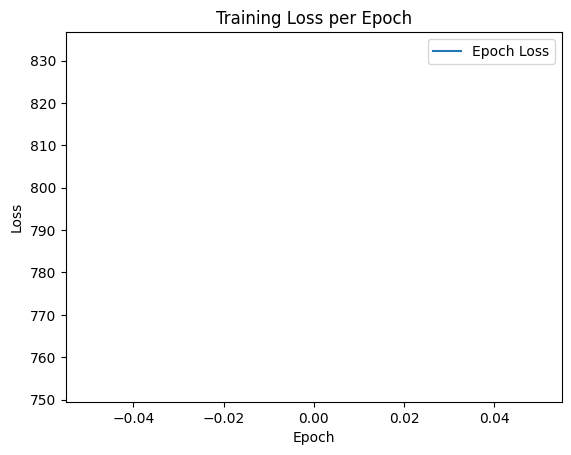

In [42]:
plt.plot(train_loss, label = 'Epoch Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.show()

In [44]:
# Checking the overall accuracy of the model on the validation set.
correct = 0
total = 0
with torch.no_grad():
    for data in validation_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the validation images: {100 * correct // total} %')

Accuracy of the network on the validation images: 86 %


In [46]:
classes = ("Pukeko", "Takahe")
# Checking the accuracy for each class on the validation set.
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in validation_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Pukeko is 88.8 %
Accuracy for class: Takahe is 72.2 %


In [ ]:
precision = precision_score(labels, predicted)
recall = recall_score(labels, predicted)
f1 = f1_score(labels, predicted)
print(f'Precision for class: {classname:5s} is {precision:.1f} %')
print(f'Recall for class: {classname:5s} is {recall:.1f} %')
print(f'F1 score for class: {classname:5s} is {f1:.1f} %')


In [ ]:
precision_weighted = precision_score(labels, predicted, average = 'weighted')
precision_macro = precision_score(labels, predicted, average = 'macro')
print("Macro Precision:", precision_macro)
print("Weighted Precision:", precision_weighted)

In [ ]:
recall_weighted = recall_score(labels, predicted, average = 'weighted')
recall_macro = recall_score(labels, predicted, average = 'macro')
print("Macro recall:", recall_macro)
print("Weighted recall:", recall_weighted)

In [ ]:
f1_weighted = f1_score(labels, predicted, average = 'weighted')
f1_macro = f1_score(labels, predicted, average = 'macro')
print("Macro F1 score:", f1_weighted)
print("Weighted F1 score:", f1_macro)

In [ ]:
# PATH = 'Models/modelC.pth'
# torch.save(model.state_dict(), PATH)